<a href="https://colab.research.google.com/github/SergeiGrudinin/deeplearning-beginners/blob/master/notebook/Execrcise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks on MNIST

This notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Originally copied from [ART.T458: Advanced Machine Learning](http://www.ocw.titech.ac.jp/index.php?module=General&action=T0300&GakubuCD=4&GakkaCD=342305&KeiCD=23&course=5&KougiCD=202004845&Nendo=2020&lang=EN&vid=03) course at [Tokyo Institute of Technology](https://www.titech.ac.jp/english/).

# Python basics
Below we will look at out first Python program (Notre premier programme python)

In [2]:
def do_something():
    return 0

def do_something_else(a):
    result = 0
    for i in a:
        # print(i,a[i])
        ...
    return result

if __name__ == '__main__':
    # do_something()
    my_dict = {"ke1":1, "key2":2, "key3":50, "key4":200}
    sum = do_something_else(my_dict)
    print("dictionary sum = ", sum)

dictionary sum =  0


<span style="color:SteelBlue"> Exercise 1</span> : modify the code such that the first function receives a list of elements and computes it sum
(modifier le code pour que la première fonction reçoive une liste d'éléments et calcule sa somme) :

`my_list = [1,2,3,4,5,6]`

`do_something(my_list)`

Also, print the type of the function input (Imprimez également le type d’entrée de fonction)

<span style="color:SteelBlue"> Exercise 2</span> : modify the code such that the second function receives a dictionary of elements and computes the sum of its values
(modifier le code de telle sorte que la deuxième fonction reçoive un dictionnaire d'éléments et calcule la somme de ses valeurs) :

`my_dict = {"ke1":1, "key2":2, "key3":50, "key4":200}`

`do_something_else(my_dict)`

Also, print the type of the function input (Imprimez également le type d’entrée de fonction)

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The code below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [3]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    # print(len(rawbuffer)) 
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-labels-idx1-ubyte.gz'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [4]:
import numpy as np
data = np.load('mnist.npz')


# print(data['train_x'].shape, data['train_x'].dtype)
# print(data['train_y'].shape, data['train_y'].dtype)
# print(data['test_x'].shape, data['test_x'].dtype)
# print(data['test_y'].shape, data['test_y'].dtype)

print(data["train_x"][5][5:15][5:15], data["train_y"][5])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.70980394 0.9882353  0.9882353
  0.8627451  0.654902   0.11764706 0.         0.         0.3019608
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.10196079 0.5019608  0.22745098
  0.08627451 0.         0.         0.         0.         0.39215687
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.6156863
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.     

<span style="color:SteelBlue"> Exercise 3</span> : print values of the 5th train image and its label (imprimer les valeurs de 5ème image 'train' et son étiquette)

<span style="color:SteelBlue"> Exercise 4</span> : print center pixels of the 5th train image, pixels from 5 to 15 only (imprimer les pixels centraux de la 5ème image, pixels de 5 à 15 uniquement)

## Visualize the dataset

2


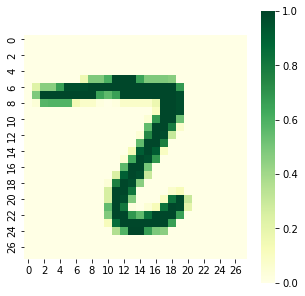

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).

data = np.load('mnist.npz')

i = 1

image = data['test_x'][i]
label = data['test_y'][i]

all_images = data['test_x']
all_images_rotated = np.rot90(all_images, 2, axes=(1,2))

image = all_images_rotated[1]
print(label)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(image, annot=False, fmt='.1f', square=True, cmap="YlGn")
plt.show()

small_training_set = data['train_x'][0:]

<span style="color:SteelBlue"> Exercise 5</span> : print images from 50 to 60 (imprimer des images de 50 à 60)

<span style="color:SteelBlue"> Exercise 6</span> : prepare a 'hard' test set with 90 degrees rotated images (préparer un ensemble de tests « durs » avec des images pivotées à 90 degrés)

<span style="color:SteelBlue"> Exercise 7</span> : prepare a 'small' training set with 10 times fewer images (préparer un « petit » ensemble de "train" avec 10 fois moins d’images)




In [5]:
s = int(data["train_x"].shape[0]/10)
print(s)
train_small = data["train_x"][0:s]


print(train_small.shape)
label_small = data["train_y"][0:s]
print(label_small.shape)


6000
(6000, 28, 28)
(6000,)


# Linear algebra basics
For the first model we will need two functions, 
- dot (inner) product between vectors, (produit scalaire entre les vecteurs)
- and argmax

<span style="color:SteelBlue"> Exercise 8</span> : write a dot product of two Python lists (écrire un produit scalaire de deux listes Python)

<span style="color:SteelBlue"> Exercise 9</span> : write a dot product of two numpy vectors (écrire un produit scalaire de deux vecteurs numpy)



In [3]:
import numpy as np

def dot_product(a,b):
    assert len(a) == len(b)
    dot = 0
    ... # exercise 8
    return dot


a = [1,2,3,4,5,6,7,8,9,10,12,23,34]
b = [2,3,4,5,6,7,8,9,10,11,10,-1,2]

print("dot (a,b) = ",dot_product(a,b))

#convert lists into numpy vectors
a_np = np.array(a)
b_np = np.array(b)

print(a_np, type(a_np), len(a_np), a_np.shape, a_np.transpose(), a_np.transpose().shape)


print("dot_np (a_np,b_np) = ",dot_product(a_np,b_np))  # exercise 9

dot (a,b) =  0
[ 1  2  3  4  5  6  7  8  9 10 12 23 34] <class 'numpy.ndarray'> 13 (13,) [ 1  2  3  4  5  6  7  8  9 10 12 23 34] (13,)
dot_np (a_np,b_np) =  0


Now, let us compute several dot products at teh same time. We will use a matrix representation with numpy for compactness (Calculons maintenant plusieurs produits scalaires en même temps. Nous utiliserons une représentation matricielle avec numpy pour plus de compacité)

<span style="color:SteelBlue"> Exercise 10</span> : write a dot(matrix) product of a numpy matrix with a numpy vector (écrire un produit scalaire (matrice) d'une matrice numpy avec un vecteur numpy)


In [4]:
import numpy as np

def dot_product(W,a):
    print(W.shape)
    print(a.shape)

    assert W.shape[-1] == a.shape[0]
    dot = []

    shape0 = W.shape[0]
    shape1 = W.shape[1]
    dot_np = np.empty(shape0)

    print(dot_np)

    for i in range(shape0):
        # dot_i = 0
        dot_np[i] = 0
        for j in range(shape1):
            # dot_i = dot_i + W[i][j]*a[j]
            dot_np[i] += W[i][j]*a[j]
        # dot.append(dot_i)
    return dot_np


a = [1,2,3,4,5,6,7,8,9,10,12,23,34]

#convert lists into numpy vectors
a_np = np.array(a)

#create a random numpy matrix
W = np.random.randn(10, len(a_np))            # (10 x 13)

# print(W)

dot = dot_product(W,a_np) # python list 
print("dot (W,a) = ", dot)  # exercise 10
print("length of the output =",len(dot))


(10, 13)
(13,)
[0.01  0.02  0.025 0.05  0.1   0.2   0.25  0.5   1.    2.   ]
dot (W,a) =  [ 11.73881094  40.73094153  25.65166869  21.22786681  -3.43425141
  26.27758097 -28.63830425  65.91845034 -21.55717501 -29.19652954]
length of the output = 10


<span style="color:SteelBlue"> Exercise 11</span> : Finally, we need to write an argmax function, which shows the index of the max elemnt in a vector Enfin, nous devons écrire une fonction argmax, qui montre l'index de l'élément max dans un vecteur)


In [5]:
import numpy as np

def argmax(a):
    indx = 0
    max_elem = a[0]
    for i in range(len(a)):
        if(a[i]>max_elem):
            max_elem = a[i]
            indx = i
    return indx


a = [10000,2,3,4,5,6,7,80,9,10,12,23,34]

#convert lists into numpy vectors
a_np = np.array(a)

print("argmax (a) = ",argmax(a_np))  # exercise 11

argmax (a) =  0


## Perceptron algorithm for single-layer neural network
Now we are ready to train our first model!!! However, we also need to convert images to vectors (Nous sommes maintenant prêts à entraîner notre premier modèle.!!! Cependant, nous devons également convertir les images en vecteurs)

<span style="color:SteelBlue"> Exercise 12</span> : An example of image conversion (Un exemple de conversion d'image)


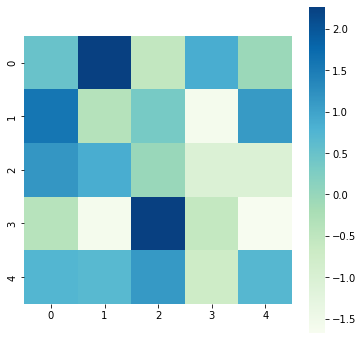

(25,)
[ 0.49302143  2.26622724 -0.5391905   0.85853682 -0.04114129  1.58749235
 -0.36236153  0.34134868 -1.60447506  1.1042902   1.14885803  0.85307002
 -0.02477157 -1.043706   -1.04311268 -0.39372771 -1.60363505  2.25920709
 -0.56696047 -1.66891437  0.73822565  0.67256634  1.12848577 -0.72327761
  0.71194014]


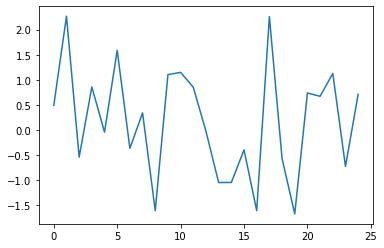

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def flatten(W):
    v = np.empty(W.shape[0]*W.shape[1])
    indx = -1
    for i in range(W.shape[0]):
        for j in range (W.shape[1]):
            indx = indx + 1
            # index = i*W.shape[0] + j
            v[indx] = W[i][j]
    # v = ... # Exercise 12, please convert a 5 x 5 matrix to a 25 vector
    return v

#create a random numpy matrix
W = np.random.randn(5, 5)            # (5 x 5)

f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(W, annot=False, fmt='.1f', square=True, cmap="GnBu")
plt.show()

v = flatten(W)

# v = np.c_[W, np.ones(5)]
print(v.shape)
print(v)

plt.plot(v)
plt.show()

<span style="color:SteelBlue"> Exercise finale</span> : Our first model

Here, we will first convert our images into vectors
<span style="color:SteelBlue"> Exercise 1 bis</span> : Use low-level reshape function for the flatten operation: **numpy.reshape(a, newshape, order='C')**, Gives a new shape to an array without changing its data.

Parameters:

>*a*
>array_like
>>Array to be reshaped.

>*newshape*
>int or tuple of ints
>>The new shape should be compatible with the original shape. If an integer, then the result will be a 1-D array of that length. One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions.

>*order*
>{‘C’, ‘F’, ‘A’}, optional
>>Read the elements of a using this index order, and place the elements into the reshaped array using this index order. ‘C’ means to read / write the elements using C-like index order, with the last axis index changing fastest, back to the first axis index changing >>slowest. ‘F’ means to read / write the elements using Fortran-like index order, with the first index changing fastest, and the last index changing slowest. Note that the ‘C’ and ‘F’ options take no account of the memory layout of the underlying array, and only refer to >>the order of indexing. ‘A’ means to read / write the elements in Fortran-like index order if a is Fortran contiguous in memory, C-like order otherwise.

Returns:
>*reshaped_array*
>ndarray
>>This will be a new view object if possible; otherwise, it will be a copy. Note there is no guarantee of the memory layout (C- or Fortran- contiguous) of the returned array.
 

In [6]:
import numpy as np

# Ex 1 bis
Xtrain = train_small.reshape()                   # Reshape to (6000 x 784)
Ytrain = label_small                             # (6000)

# Ex 1 bis                                          
Xtest = data['test_x'].reshape()               # Reshape to (10000 x 785)
Ytest = data['test_y']                        # (10000)


Now, we can try to visualize our training set / Maintenant, nous pouvons visualiser notre données d'entraînement
We will only plot the data in the most 'principle' two dimensions, instead of the original 784 dimensions / Nous tracerons les données dans les deux dimensions les plus « principales », au lieu des 784 dimensions d'origine.

For this, we will use the Principle Component Analysis technique that determines the most principle dimensions / Pour cela, nous utiliserons la technique d’analyse en composantes principales qui détermine la plupart des dimensions principales.

If you are interested, look into singular value decomposition (SVD)

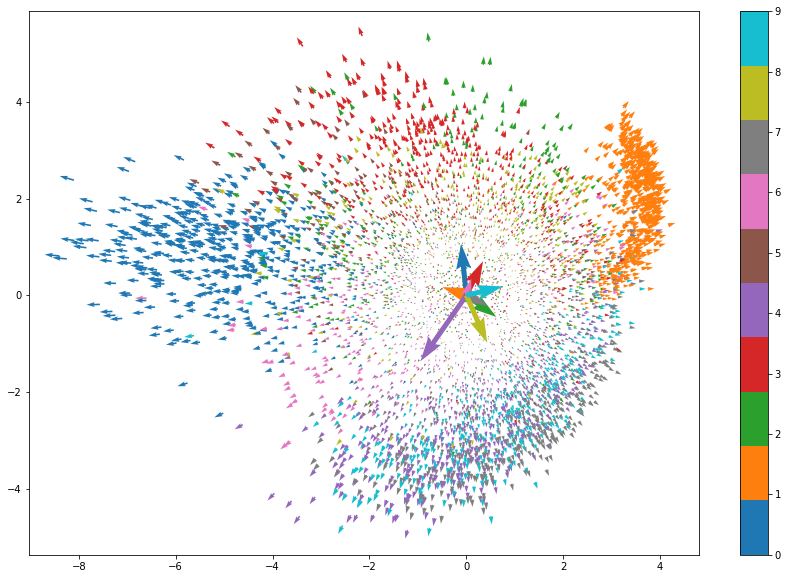

In [25]:
#visualization part
import matplotlib.pyplot as plt

X_cent = (Xtrain - Xtrain.mean(axis = 0))

#dimensionalisty reduction part, to plot dimension 784 on a x-y plane!
U, S, Vt =  np.linalg.svd(X_cent, full_matrices=False)
V = Vt.T
# S = np.diag(S)
# PCs = U.dot(S)      # it's the same as X_cent@V!
PCs = X_cent@V


f, ax = plt.subplots(figsize=(15, 10))
sc = plt.quiver( PCs[:,0],PCs[:,1], PCs[:,0],PCs[:,1], Ytrain, cmap='tab10')

W = np.random.randn(10, 28*28)            # (10 x 784), initial weights
W_proj = W@V                              # these are the projections on the XY
sc1 = plt.quiver( np.zeros(10),np.zeros(10), W_proj[:,0],W_proj[:,1], range(10), cmap='tab10')


plt.colorbar(sc)
plt.show()


<span style="color:SteelBlue"> Exercise 2 bis</span> : 
- Which classes (digits) are well separeted by principle dimensions 0 and 1? Which are not separeted? can you try other principle dimensions to see if these digits start to be separated?
- What about rotated images, do they look the same on this plot?
- Try to visualize the ten trained vectors W projected on the *xy* plane in the same way (see example above and adjust their length!)

# Finally, this is the version using numpy low-level functions
<span style="color:SteelBlue"> Exercise 3 bis</span> : Adapt this code by using numpy built-in functions numpy.argmax and the matrix-vector product "@". You may also use numpy.dot.

In [34]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython import display
from IPython.display import Image
import ipywidgets as widgets
import threading
import time

def showVectors(W):
    f, ax = plt.subplots(figsize=(15, 10))
    sc = plt.quiver( PCs[:,0],PCs[:,1], PCs[:,0],PCs[:,1], Ytrain, cmap='tab10')

    W_proj = W@V                              # these are the projections on the XY
    sc1 = plt.quiver( np.zeros(10),np.zeros(10), W_proj[:,0],W_proj[:,1], range(10), cmap='tab10')
    plt.show()
    display.clear_output(wait=True)
    time.sleep(00)
    return

In [38]:
W = np.random.randn(10, 28*28)            # (10 x 784), initial weights

eta = 0.001
for t in range(10):

    showVectors(W)
    
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):

        # Ex 3bis
        dot = W@x                    # substitute your dot product function / remplacez par votre fonction de produit scalaire
        y_pred = np.argmax(dot)                    # substitute your argmax / remplacez par votre argmax
        
        if y_pred != y:
            W[y] += x*eta                         # we need to increase the dot product... How can we do this? / 
                                                # nous devons augmenter le produit scalaire... Comment pouvons-nous faire cela ?
            W[y_pred] -= x*eta                    # we need to decreases the dot product... How can we do this? / 
                                                # nous devons diminuer le produit scalaire... Comment pouvons-nous faire cela ?
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        dot = ...           ## Ex 3bis
        y_pred = ...        ## Ex 3bis
        if y_pred == y:
            num_correct_test += 1
    
    print('#{}: train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

#9: train_accuracy=0.7617, test_accuracy=0.0000


<span style="color:SteelBlue"> Exercise 4 bis</span> : Plot misclissified images with the corresponding lables 
- Also plot their *xy* vector representation and compare with the classification vectors W
- You can also plot the vectors W and how they change with time t during the training

<span style="color:SteelBlue"> Exercise 5 bis</span> : Measure the time difference for one iteration between Python version of argmax and dot and the low-level Numpy version. 
- What is the speed-up of the numpy version? 
- Does it depend on the machine (Mac/PC)? 
- Does it depend on the size of the vecotrs/matrices? 
- Does it depend on the size of the training set.